In [3776]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3777]:
# Insert name of project
project = "antlr"

# Designite Metrics

In [3778]:
df_types = pd.read_csv(f'data/designite-{project}/TypeMetrics.csv', usecols=["Package Name", "Type Name", "NOF", "NOM", "NOPF", "NOPM", "LOC", "WMC", "NC", "DIT", "LCOM", "FANIN", "FANOUT"])
df_types.insert(0, "DeclarableId", df_types[['Package Name', 'Type Name']].agg('.'.join, axis=1))
df_types.drop(["Package Name", "Type Name"], axis="columns", inplace=True)

df_methods = pd.read_csv(f'data/designite-{project}/MethodMetrics.csv', usecols=["Package Name", "Type Name", "Method Name", "LOC", "CC", "PC"])
df_methods.insert(0, "DeclarableId", df_methods[['Package Name', 'Type Name']].agg('.'.join, axis=1))
df_methods["DeclarableId"] = df_methods[['DeclarableId', 'Method Name']].agg('://'.join, axis=1)
df_methods.drop(["Package Name", "Type Name", "Method Name"], axis="columns", inplace=True)

In [3779]:
print(df_types)

                                  DeclarableId  NOF  NOPF  NOM  NOPM  LOC  \
0             org.antlr.v4.misc.OrderedHashMap    1     0    6     6   32   
1               org.antlr.v4.misc.FrequencySet    0     0    2     2   20   
2                      org.antlr.v4.misc.Graph    3     2    4     4   63   
3                 org.antlr.v4.misc.Graph.Node    2     2    0     0   14   
4      org.antlr.v4.misc.EscapeSequenceParsing    5     5    2     1  117   
..                                         ...  ...   ...  ...   ...  ...   
250           org.antlr.v4.tool.ast.RuleRefAST    0     0    6     6   26   
251             org.antlr.v4.tool.ast.BlockAST    2     2    7     7   28   
252  org.antlr.v4.tool.ast.GrammarASTErrorNode    1     0    5     5   21   
253           org.antlr.v4.tool.ast.GrammarAST    3     3   24    24  180   
254               org.antlr.v4.tool.ast.AltAST    3     3    7     7   38   

     WMC  NC  DIT  LCOM  FANIN  FANOUT  
0      7   0    0   0.0      2    

In [3780]:
print(df_methods)

                                       DeclarableId  LOC  CC  PC
0         org.antlr.v4.misc.OrderedHashMap://getKey    3   1   1
1     org.antlr.v4.misc.OrderedHashMap://getElement    3   1   1
2            org.antlr.v4.misc.OrderedHashMap://put    4   1   2
3         org.antlr.v4.misc.OrderedHashMap://putAll    5   2   1
4         org.antlr.v4.misc.OrderedHashMap://remove    4   1   1
...                                             ...  ...  ..  ..
1506          org.antlr.v4.tool.ast.AltAST://AltAST    3   1   1
1507          org.antlr.v4.tool.ast.AltAST://AltAST    3   1   2
1508          org.antlr.v4.tool.ast.AltAST://AltAST    3   1   3
1509         org.antlr.v4.tool.ast.AltAST://dupNode    3   1   0
1510           org.antlr.v4.tool.ast.AltAST://visit    3   1   1

[1511 rows x 4 columns]


# SonarQube metrics

In [3781]:
df_sonar = pd.read_csv(f'data/sonarqube-{project}/CognitiveComplexity.csv', usecols=["DeclarableId","S_COCO", "S_LOC"])
df_sonar['DeclarableId'] = df_sonar['DeclarableId'].astype(str)
pd.to_numeric(df_sonar['S_COCO'])
pd.to_numeric(df_sonar['S_LOC'])
print(df_sonar)

                                         DeclarableId  S_COCO  S_LOC
0                                   org.antlr.v4.Tool     216      0
1                 org.antlr.v4.semantics.SymbolChecks     184      0
2               org.antlr.v4.automata.LexerATNFactory     182      0
3          org.antlr.v4.tool.GrammarTransformPipeline     180      0
4                           org.antlr.v4.tool.Grammar     168      0
..                                                ...     ...    ...
227                 org.antlr.v4.gui.TreeTextProvider       0      0
228      org.antlr.v4.codegen.target.TypeScriptTarget       0      0
229              org.antlr.v4.parse.v4ParserException       0      0
230  org.antlr.v4.codegen.model.VisitorDispatchMethod       0      0
231               org.antlr.v4.codegen.model.Wildcard       0      0

[232 rows x 3 columns]


# LAMP Metrics

In [3782]:
df_modules = pd.read_csv(f'data/lamp-{project}/modules.csv', usecols=["DeclarableId","MLOC","WMC","CWMC","DIT","NOC","CBO","RFC","LCOM","NOU","LC"])
df_units = pd.read_csv(f'data/lamp-{project}/units.csv', usecols=["DeclarableId","ULOC","CC","COCO","PC","LLOC"])

In [3783]:
df_modules.sort_values(by=["DeclarableId"])
print(df_modules)

                                                   DeclarableId  MLOC  WMC  \
0                    org.antlr.v4.tool.GrammarTransformPipeline   337   80   
1                     org.antlr.v4.codegen.model.chunk.TokenRef     5    1   
2    org.antlr.v4.codegen.model.decl.ContextTokenListGetterDecl    11    3   
3     org.antlr.v4.codegen.model.chunk.TokenPropertyRef_channel     5    1   
4                 org.antlr.v4.codegen.model.decl.TokenListDecl     5    1   
..                                                          ...   ...  ...   
226                                     org.antlr.v4.misc.Utils   109   35   
227                 org.antlr.v4.codegen.model.BaseListenerFile     5    1   
228                            org.antlr.v4.automata.ATNFactory    39   26   
229                    org.antlr.v4.codegen.model.SerializedATN    12    3   
230                org.antlr.v4.codegen.BlankOutputModelFactory    26   24   

     CWMC  DIT  NOC  CBO  RFC  LCOM  NOU  LC  
0     174    0  

In [3784]:
print(df_units)

                                                                                       DeclarableId  \
0     org.antlr.v4.tool.GrammarTransformPipeline://GrammarTransformPipeline.constructor$[43:8,46:1]   
1                                  org.antlr.v4.tool.GrammarTransformPipeline://process$[48:8,58:1]   
2                       org.antlr.v4.tool.GrammarTransformPipeline://reduceBlocksToSets$[60:8,66:1]   
3                org.antlr.v4.tool.GrammarTransformPipeline://expandParameterizedLoops$[76:11,89:4]   
4                 org.antlr.v4.tool.GrammarTransformPipeline://expandParameterizedLoop$[91:11,94:4]   
...                                                                                             ...   
1505              org.antlr.v4.codegen.BlankOutputModelFactory://getComplexChoiceBlock$[92:8,92:97]   
1506                    org.antlr.v4.codegen.BlankOutputModelFactory://getLL1EBNFBlock$[95:8,95:95]   
1507                org.antlr.v4.codegen.BlankOutputModelFactory://getCom

## Distribution analysis

In [3785]:
print(df_modules.describe())

             MLOC         WMC        CWMC         DIT         NOC         CBO  \
count  231.000000  231.000000  231.000000  231.000000  231.000000  231.000000   
mean    62.251082   16.095238   13.909091    1.705628    0.627706   39.662338   
std    114.840484   30.924727   33.677182    1.549169    1.776639   82.069474   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      7.000000    1.000000    0.000000    0.000000    0.000000    1.000000   
50%     17.000000    5.000000    0.000000    1.000000    0.000000    5.000000   
75%     57.500000   14.500000    7.500000    3.000000    0.000000   32.500000   
max    808.000000  234.000000  210.000000    6.000000   11.000000  502.000000   

              RFC        LCOM         NOU          LC  
count  231.000000  231.000000  231.000000  231.000000  
mean    12.952381    1.813853    6.536797    0.008658  
std     25.141900    3.135349   10.764563    0.092846  
min      0.000000    0.000000    0.000000    0

Within the codebase, inheritance and lambdas are rarely used.

Let's deepdive into lambdas that are used.

In [3786]:
df_lambda = df_modules.loc[df_modules["LC"] > 0][['DeclarableId', 'LC']]
print(df_lambda)

                               DeclarableId  LC
20   org.antlr.v4.codegen.model.VisitorFile   1
78  org.antlr.v4.codegen.model.ListenerFile   1


Lambdas are used in 5 places of the code base. These lambda statements were very short. Only describing a call to another method.

In [3787]:
print(df_units.describe())

              ULOC           CC         COCO           PC         LLOC
count  1510.000000  1510.000000  1510.000000  1510.000000  1510.000000
mean      8.025828     2.462252     2.127815     1.386093     0.001325
std      12.107427     3.417430     6.622368     1.245777     0.036382
min       1.000000     1.000000     0.000000     0.000000     0.000000
25%       3.000000     1.000000     0.000000     1.000000     0.000000
50%       4.000000     1.000000     0.000000     1.000000     0.000000
75%       9.000000     2.000000     1.000000     2.000000     0.000000
max     168.000000    43.000000   125.000000    10.000000     1.000000


# Analysing module differences

In [3788]:
module_diff = pd.concat([df_types["DeclarableId"], df_modules["DeclarableId"]]).drop_duplicates(keep=False)
print(module_diff)

3                                                org.antlr.v4.misc.Graph.Node
5                              org.antlr.v4.misc.EscapeSequenceParsing.Result
6                                org.antlr.v4.misc.EscapeSequenceParsing.Type
8                                              org.antlr.v4.misc.Utils.Filter
9                                               org.antlr.v4.misc.Utils.Func0
10                                              org.antlr.v4.misc.Utils.Func1
17                    org.antlr.v4.automata.LexerATNFactory.CharSetParseState
18                                 org.antlr.v4.automata.LexerATNFactory.Mode
21                                    org.antlr.v4.automata.ATNFactory.Handle
28                      org.antlr.v4.analysis.LeftRecursiveRuleAnalyzer.ASSOC
129                           org.antlr.v4.codegen.model.TestSetInline.Bitset
185                                           org.antlr.v4.Tool.OptionArgType
186                                                  org.antlr.v

33 Modules aren't support by the LAMP framework due to inner modules not being supported.

In [3789]:
unit_diff = pd.concat([df_methods["DeclarableId"], df_units["DeclarableId"].apply(lambda s: s.split("$")[0])]).drop_duplicates(keep=False)
print(unit_diff)

26                                                   org.antlr.v4.misc.MutableInt://MutableInt
43                 org.antlr.v4.automata.CharactersDataCheckStatus://CharactersDataCheckStatus
44                                               org.antlr.v4.automata.ATNPrinter://ATNPrinter
47                                   org.antlr.v4.automata.ParserATNFactory://ParserATNFactory
125                                          org.antlr.v4.automata.ATNOptimizer://ATNOptimizer
                                                 ...                                          
1420    org.antlr.v4.codegen.model.chunk.RulePropertyRef_ctx://RulePropertyRef_ctx.constructor
1426                                    org.antlr.v4.codegen.model.Choice://Choice.constructor
1431                    org.antlr.v4.semantics.SemanticPipeline://SemanticPipeline.constructor
1442            org.antlr.v4.codegen.model.chunk.RulePropertyRef://RulePropertyRef.constructor
1456                org.antlr.v4.codegen.model.Bas

261 Units aren't recognized by the LAMP framework at a first glance. When looking at each method precisely, we see that constructors and initializers aren't being matched by name due to their naming conventions within the LAMP framework.

In [3790]:
unit_diff_with_constructors = pd.concat([df_methods["DeclarableId"], df_units["DeclarableId"].apply(lambda s:
                                                                                                        s.split("$")[0].removesuffix(".constructor").removesuffix(".initializer")
                                                                                                    )]).drop_duplicates(keep=False)
print(unit_diff_with_constructors)

332         org.antlr.v4.semantics.UseDefAnalyzer://nonLocalAttr
333        org.antlr.v4.semantics.UseDefAnalyzer://qualifiedAttr
334              org.antlr.v4.semantics.UseDefAnalyzer://setAttr
335     org.antlr.v4.semantics.UseDefAnalyzer://setExprAttribute
336      org.antlr.v4.semantics.UseDefAnalyzer://setNonLocalAttr
337                 org.antlr.v4.semantics.UseDefAnalyzer://attr
622               org.antlr.v4.codegen.Target://compileTimeError
623                   org.antlr.v4.codegen.Target://runTimeError
624                        org.antlr.v4.codegen.Target://IOError
625                  org.antlr.v4.codegen.Target://internalError
626                    org.antlr.v4.codegen.Target://reportError
993                     org.antlr.v4.gui.GraphicsSupport://print
1013                  org.antlr.v4.gui.TreeViewer://stateChanged
1014                  org.antlr.v4.gui.TreeViewer://valueChanged
1015                 org.antlr.v4.gui.TreeViewer://windowClosing
1018                     

After removing the .constructor and .initializer from the declarable id, we see that these units are now matched to their corresponding method ids from designite.
This leaves us with the analysis of the remaining 18 units that aren't getting matched. These are units:

- Enum declarations by the LAMP framework, these aren't evaluated by Designite.
- Anonymous class declarations: these aren't evaluated by the LAMP framework
- Inner Module Units: these aren't evaluated by the LAMP framework.

# Metric performance

In [3791]:
types = df_types
methods = df_methods

mods = df_modules
units = df_units

types.rename(columns=lambda x: "D_" + x, inplace=True)
types.rename({"D_DeclarableId": "DeclarableId"}, axis=1, inplace=True)

methods.rename(columns=lambda x: "D_" + x, inplace=True)
methods.rename({"D_DeclarableId": "DeclarableId"}, axis=1, inplace=True)

mods.rename(columns=lambda x: "L_" + x, inplace=True)
mods.rename({"L_DeclarableId": "DeclarableId"}, axis=1, inplace=True)

units.rename(columns=lambda x: "L_" + x, inplace=True)
units.rename({"L_DeclarableId": "DeclarableId"}, axis=1, inplace=True)
units["DeclarableId"] = units["DeclarableId"].apply(lambda s: s.split("$")[0].removesuffix(".constructor").removesuffix(".initializer"))

In [3792]:
m_mods = pd.merge(types, mods, on="DeclarableId")
m_mods = pd.merge(m_mods, df_sonar, on="DeclarableId")
print(m_mods)

                                  DeclarableId  D_NOF  D_NOPF  D_NOM  D_NOPM  \
0             org.antlr.v4.misc.OrderedHashMap      1       0      6       6   
1               org.antlr.v4.misc.FrequencySet      0       0      2       2   
2                      org.antlr.v4.misc.Graph      3       2      4       4   
3      org.antlr.v4.misc.EscapeSequenceParsing      5       5      2       1   
4                      org.antlr.v4.misc.Utils      1       1     12      12   
..                                         ...    ...     ...    ...     ...   
224           org.antlr.v4.tool.ast.RuleRefAST      0       0      6       6   
225             org.antlr.v4.tool.ast.BlockAST      2       2      7       7   
226  org.antlr.v4.tool.ast.GrammarASTErrorNode      1       0      5       5   
227           org.antlr.v4.tool.ast.GrammarAST      3       3     24      24   
228               org.antlr.v4.tool.ast.AltAST      3       3      7       7   

     D_LOC  D_WMC  D_NC  D_DIT  D_LCOM 

In [3793]:
print(units.count())
print(methods.count())

print(4652 + 4568)

DeclarableId    1510
L_ULOC          1510
L_CC            1510
L_COCO          1510
L_PC            1510
L_LLOC          1510
dtype: int64
DeclarableId    1511
D_LOC           1511
D_CC            1511
D_PC            1511
dtype: int64
9220


In [3794]:
ucol = units.groupby("DeclarableId")[['L_CC', 'L_PC', "L_ULOC"]].sum().reset_index()
ucol

,DeclarableId,L_CC,L_PC,L_ULOC
0,org.antlr.v4.Tool://Tool,3,1,11
1,org.antlr.v4.Tool://addListener,2,1,3
2,org.antlr.v4.Tool://checkForRuleIssues,10,1,30
3,org.antlr.v4.Tool://createGrammar,3,1,6
4,org.antlr.v4.Tool://error,3,1,7
...,...,...,...,...
1315,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeIntPropertyCodesToNames,4,1,16
1316,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeScriptCodesToNames,1,1,3
1317,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeSetToIntervalSet,2,2,5
1318,org.antlr.v4.unicode.UnicodeDataTemplateController://getProperties,1,0,19


In [3795]:
mcol = methods.groupby("DeclarableId")[['D_CC', 'D_PC', "D_LOC"]].sum().reset_index()
mcol

,DeclarableId,D_CC,D_PC,D_LOC
0,org.antlr.v4.Tool://Tool,2,1,10
1,org.antlr.v4.Tool://addListener,2,1,3
2,org.antlr.v4.Tool://checkForRuleIssues,8,1,49
3,org.antlr.v4.Tool://createGrammar,2,1,7
4,org.antlr.v4.Tool://error,3,1,7
...,...,...,...,...
1340,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeIntPropertyCodesToNames,3,1,16
1341,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeScriptCodesToNames,1,1,3
1342,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeSetToIntervalSet,2,2,5
1343,org.antlr.v4.unicode.UnicodeDataTemplateController://getProperties,1,0,19


In [3796]:
m_units = pd.merge(ucol, mcol, on="DeclarableId")
m_units

,DeclarableId,L_CC,L_PC,L_ULOC,D_CC,D_PC,D_LOC
0,org.antlr.v4.Tool://Tool,3,1,11,2,1,10
1,org.antlr.v4.Tool://addListener,2,1,3,2,1,3
2,org.antlr.v4.Tool://checkForRuleIssues,10,1,30,8,1,49
3,org.antlr.v4.Tool://createGrammar,3,1,6,2,1,7
4,org.antlr.v4.Tool://error,3,1,7,3,1,7
...,...,...,...,...,...,...,...
1311,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeIntPropertyCodesToNames,4,1,16,3,1,16
1312,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeScriptCodesToNames,1,1,3,1,1,3
1313,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeSetToIntervalSet,2,2,5,2,2,5
1314,org.antlr.v4.unicode.UnicodeDataTemplateController://getProperties,1,0,19,1,0,19


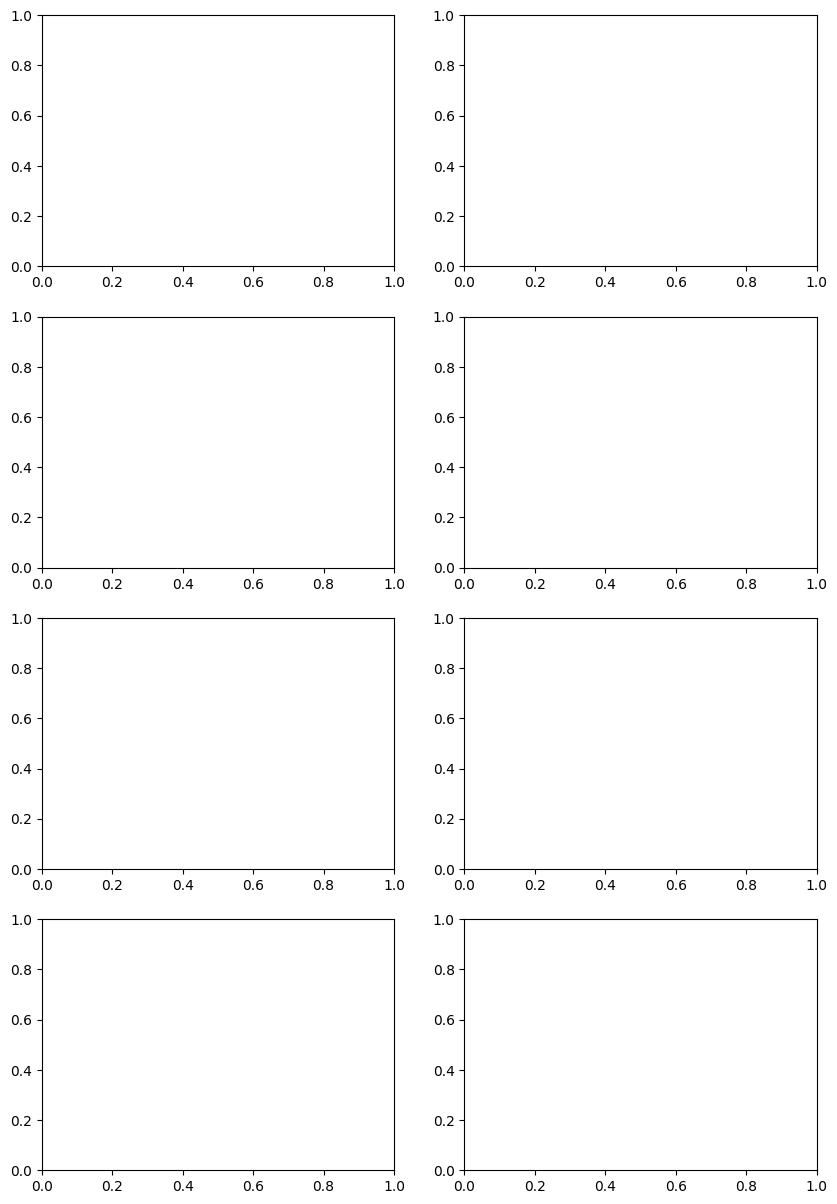

In [3797]:
figure, axis = plt.subplots(4, 2, figsize=(10, 15))

## Module Lines Of Code

In [3798]:
mloc = m_mods[['DeclarableId', 'D_LOC', 'L_MLOC']]
print(mloc)

                                  DeclarableId  D_LOC  L_MLOC
0             org.antlr.v4.misc.OrderedHashMap     32      22
1               org.antlr.v4.misc.FrequencySet     20      17
2                      org.antlr.v4.misc.Graph     63      50
3      org.antlr.v4.misc.EscapeSequenceParsing    117     143
4                      org.antlr.v4.misc.Utils    119     109
..                                         ...    ...     ...
224           org.antlr.v4.tool.ast.RuleRefAST     26      15
225             org.antlr.v4.tool.ast.BlockAST     28      15
226  org.antlr.v4.tool.ast.GrammarASTErrorNode     21      12
227           org.antlr.v4.tool.ast.GrammarAST    180     165
228               org.antlr.v4.tool.ast.AltAST     38      17

[229 rows x 3 columns]


In [3799]:
x1 = mloc['D_LOC']
# x2 = mloc['S_LOC']
x3 = mloc['L_MLOC']

plt = axis[0, 0]

# Plot
# plt.hist([x1, x2, x3], bins=np.linspace(0, 1000, 30), density=True, color=['#3C5DA1', '#B53941', '#469B55'], label=['Designite', 'SonarQube', 'LAMP'])
plt.hist([x1, x3], bins=np.linspace(0, 1000, 30), density=True, color=['#3C5DA1', '#469B55'], label=['Designite', 'LAMP'])
plt.set(title= "MLOC Distribution", xlabel= 'Module Lines of Code', ylabel='Density')
plt.legend()
# plt.savefig('images/lottie-MLOC.png')
# plt.show()

## Module Number Of Units

In [3800]:
nou = m_mods[['DeclarableId', 'D_NOM', 'L_NOU']]
print(nou)

                                  DeclarableId  D_NOM  L_NOU
0             org.antlr.v4.misc.OrderedHashMap      6      6
1               org.antlr.v4.misc.FrequencySet      2      2
2                      org.antlr.v4.misc.Graph      4      4
3      org.antlr.v4.misc.EscapeSequenceParsing      2      2
4                      org.antlr.v4.misc.Utils     12     12
..                                         ...    ...    ...
224           org.antlr.v4.tool.ast.RuleRefAST      6      6
225             org.antlr.v4.tool.ast.BlockAST      7      7
226  org.antlr.v4.tool.ast.GrammarASTErrorNode      5      5
227           org.antlr.v4.tool.ast.GrammarAST     24     24
228               org.antlr.v4.tool.ast.AltAST      7      7

[229 rows x 3 columns]


In [3801]:
x1 = m_mods['D_NOM']
x2 = m_mods['L_NOU']

plt = axis[0, 1]

# Plot
plt.hist([x1, x2], bins=np.linspace(0, 50, 30), density=True, label=['Designite', 'LAMP'])
plt.set(title= "NOU Distribution", xlabel= 'Number of Units', ylabel='Density')
plt.legend()
# plt.savefig('images/lottie-NOU.png')
# plt.show()

## Module Weighted Method per Class (WMC)

In [3802]:
wmc = m_mods[['DeclarableId', 'D_WMC', 'L_WMC']]
print(wmc)

                                  DeclarableId  D_WMC  L_WMC
0             org.antlr.v4.misc.OrderedHashMap      7      7
1               org.antlr.v4.misc.FrequencySet      4      5
2                      org.antlr.v4.misc.Graph     12     12
3      org.antlr.v4.misc.EscapeSequenceParsing     18     26
4                      org.antlr.v4.misc.Utils     32     35
..                                         ...    ...    ...
224           org.antlr.v4.tool.ast.RuleRefAST      6      6
225             org.antlr.v4.tool.ast.BlockAST      7      7
226  org.antlr.v4.tool.ast.GrammarASTErrorNode      5      5
227           org.antlr.v4.tool.ast.GrammarAST     54     58
228               org.antlr.v4.tool.ast.AltAST      7      7

[229 rows x 3 columns]


In [3803]:
x1 = m_mods['D_WMC']
x2 = m_mods['L_WMC']


plt = axis[1, 0]

# Plot
plt.hist([x1, x2], bins=np.linspace(0, 100, 30), density=True, label=['Designite', 'LAMP'])
plt.set(title= "WMC Distribution", xlabel= 'Weighted Methods per Class', ylabel='Density')
plt.legend()
# plt.savefig('images/lottie-WMC.png')
# plt.show()

## Module - Cognitively Weighted Method per Class (CWMC)

In [3804]:
cwmc = m_mods[['DeclarableId', 'S_COCO', 'L_CWMC']].copy()
print(cwmc)

                                  DeclarableId  S_COCO  L_CWMC
0             org.antlr.v4.misc.OrderedHashMap       1       1
1               org.antlr.v4.misc.FrequencySet       3       3
2                      org.antlr.v4.misc.Graph      15      13
3      org.antlr.v4.misc.EscapeSequenceParsing      42      39
4                      org.antlr.v4.misc.Utils      29      29
..                                         ...     ...     ...
224           org.antlr.v4.tool.ast.RuleRefAST       0       0
225             org.antlr.v4.tool.ast.BlockAST       0       0
226  org.antlr.v4.tool.ast.GrammarASTErrorNode       0       0
227           org.antlr.v4.tool.ast.GrammarAST      48      48
228               org.antlr.v4.tool.ast.AltAST       0       0

[229 rows x 3 columns]


In [3805]:
cwmc["Diff"] = cwmc["S_COCO"] - cwmc["L_CWMC"]
print(cwmc.loc[cwmc["Diff"] > 5])

                                   DeclarableId  S_COCO  L_CWMC  Diff
171                           org.antlr.v4.Tool     216     210     6
195  org.antlr.v4.tool.GrammarTransformPipeline     180     174     6


In [3806]:
x1 = m_mods['S_COCO']
x2 = m_mods['L_CWMC']

plt = axis[1, 1]

# Plot
plt.hist([x1, x2], bins=np.linspace(0, 100, 30), density=True, color=['#B53941', '#469B55'], label=['SonarQube', 'LAMP'])
plt.set(title= "CWMC Distribution", xlabel= 'Cognitively Weighted Methods per Class', ylabel='Density')
plt.legend()
# plt.savefig('images/lottie-CWMC.png')
# plt.show()

## Module Depth of Inheritance (DIT)

In [3807]:
dit = m_mods[['DeclarableId', 'D_DIT', 'L_DIT']]
print(dit)

                                  DeclarableId  D_DIT  L_DIT
0             org.antlr.v4.misc.OrderedHashMap      0      1
1               org.antlr.v4.misc.FrequencySet      0      1
2                      org.antlr.v4.misc.Graph      0      0
3      org.antlr.v4.misc.EscapeSequenceParsing      0      0
4                      org.antlr.v4.misc.Utils      0      0
..                                         ...    ...    ...
224           org.antlr.v4.tool.ast.RuleRefAST      2      3
225             org.antlr.v4.tool.ast.BlockAST      2      3
226  org.antlr.v4.tool.ast.GrammarASTErrorNode      1      2
227           org.antlr.v4.tool.ast.GrammarAST      0      1
228               org.antlr.v4.tool.ast.AltAST      2      3

[229 rows x 3 columns]


In [3808]:
dit["Diff"] = dit["D_DIT"] - dit["L_DIT"]
print(dit.loc[dit["Diff"] > 0])

                                           DeclarableId  D_DIT  L_DIT  Diff
32   org.antlr.v4.semantics.BlankActionSplitterListener      1      0     1
40                    org.antlr.v4.codegen.LexerFactory      3      2     1
42                   org.antlr.v4.codegen.ParserFactory      3      2     1
44       org.antlr.v4.codegen.DefaultOutputModelFactory      2      1     1
45         org.antlr.v4.codegen.BlankOutputModelFactory      1      0     1
191                 org.antlr.v4.tool.LeftRecursiveRule      2      1     1
200               org.antlr.v4.tool.DefaultToolListener      1      0     1
205                       org.antlr.v4.tool.Alternative      1      0     1
207                              org.antlr.v4.tool.Rule      1      0     1


/var/folders/yg/_h7_f_ps1g53dn06sw9cr3gr0000gn/T/ipykernel_57397/1400901144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dit["Diff"] = dit["D_DIT"] - dit["L_DIT"]


In [3809]:
x1 = m_mods['D_DIT']
x2 = m_mods['L_DIT']

plt = axis[2, 0]

# Plot
plt.hist([x1, x2], bins=np.linspace(0, 6, 10), density=True, label=['Designite', 'LAMP'])
plt.set(title= "DIT Distribution", xlabel= 'Depth of Inheritance Tree', ylabel='Density')
plt.legend()
# plt.savefig('images/lottie-DIT.png')
# plt.show()

## Module - Number of Children

In [3810]:
noc = m_mods[['DeclarableId', 'D_NC', 'L_NOC']]
print(noc)

                                  DeclarableId  D_NC  L_NOC
0             org.antlr.v4.misc.OrderedHashMap     0      0
1               org.antlr.v4.misc.FrequencySet     0      0
2                      org.antlr.v4.misc.Graph     0      0
3      org.antlr.v4.misc.EscapeSequenceParsing     0      0
4                      org.antlr.v4.misc.Utils     0      0
..                                         ...   ...    ...
224           org.antlr.v4.tool.ast.RuleRefAST     0      0
225             org.antlr.v4.tool.ast.BlockAST     0      0
226  org.antlr.v4.tool.ast.GrammarASTErrorNode     0      0
227           org.antlr.v4.tool.ast.GrammarAST     8      8
228               org.antlr.v4.tool.ast.AltAST     0      0

[229 rows x 3 columns]


In [3811]:
x1 = m_mods['D_NC']
x2 = m_mods['L_NOC']

plt = axis[2, 1]

# Plot
plt.hist([x1, x2], bins=np.linspace(0, 10, 10), density=True, label=['Designite', 'LAMP'])
plt.set(title= "NOC Distribution", xlabel= 'Number of Children', ylabel='Density')
plt.legend()
# plt.savefig('images/lottie-NOC.png')
# plt.show()

## Module - Lack of Cohesion in Methods (LCOM)

In [3812]:
lcom = m_mods[['DeclarableId', 'D_LCOM', 'L_LCOM']]
print(lcom)

                                  DeclarableId  D_LCOM  L_LCOM
0             org.antlr.v4.misc.OrderedHashMap     0.0       1
1               org.antlr.v4.misc.FrequencySet    -1.0       1
2                      org.antlr.v4.misc.Graph     0.0       1
3      org.antlr.v4.misc.EscapeSequenceParsing     1.0       1
4                      org.antlr.v4.misc.Utils     1.0       2
..                                         ...     ...     ...
224           org.antlr.v4.tool.ast.RuleRefAST    -1.0       1
225             org.antlr.v4.tool.ast.BlockAST     1.0       1
226  org.antlr.v4.tool.ast.GrammarASTErrorNode     0.0       1
227           org.antlr.v4.tool.ast.GrammarAST     1.0       1
228               org.antlr.v4.tool.ast.AltAST     1.0       1

[229 rows x 3 columns]


## Unit - Lines of Code

In [3813]:
uloc = m_units[['DeclarableId', 'D_LOC', 'L_ULOC']]
print(uloc)

                                                                                DeclarableId  \
0                                                                   org.antlr.v4.Tool://Tool   
1                                                            org.antlr.v4.Tool://addListener   
2                                                     org.antlr.v4.Tool://checkForRuleIssues   
3                                                          org.antlr.v4.Tool://createGrammar   
4                                                                  org.antlr.v4.Tool://error   
...                                                                                      ...   
1311  org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeIntPropertyCodesToNames   
1312       org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeScriptCodesToNames   
1313         org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeSetToIntervalSet   
1314                      org.antlr.v4.u

## Unit - Cyclomatic Complexity

In [3814]:
cc = m_units[['DeclarableId', 'D_CC', 'L_CC']]
print(cc)

                                                                                DeclarableId  \
0                                                                   org.antlr.v4.Tool://Tool   
1                                                            org.antlr.v4.Tool://addListener   
2                                                     org.antlr.v4.Tool://checkForRuleIssues   
3                                                          org.antlr.v4.Tool://createGrammar   
4                                                                  org.antlr.v4.Tool://error   
...                                                                                      ...   
1311  org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeIntPropertyCodesToNames   
1312       org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeScriptCodesToNames   
1313         org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeSetToIntervalSet   
1314                      org.antlr.v4.u

In [3815]:
x1 = m_units['D_CC']
x2 = m_units['L_CC']

plt = axis[3, 0]

# Plot
plt.hist([x1, x2], bins=np.linspace(0, 10, 10), density=True, label=['Designite', 'LAMP'])
plt.set(title= "CC Distribution", xlabel= 'Cyclomatic Complexity', ylabel='Density')
plt.legend()
# plt.savefig('images/lottie-CC.png')
# plt.show()

## Unit - Parameter Count

In [3816]:
pc = m_units[['DeclarableId', 'D_PC', 'L_PC']]
print(pc)

                                                                                DeclarableId  \
0                                                                   org.antlr.v4.Tool://Tool   
1                                                            org.antlr.v4.Tool://addListener   
2                                                     org.antlr.v4.Tool://checkForRuleIssues   
3                                                          org.antlr.v4.Tool://createGrammar   
4                                                                  org.antlr.v4.Tool://error   
...                                                                                      ...   
1311  org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeIntPropertyCodesToNames   
1312       org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeScriptCodesToNames   
1313         org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeSetToIntervalSet   
1314                      org.antlr.v4.u

In [3817]:
x1 = m_units['D_PC']
x2 = m_units['L_PC']

plt = axis[3, 1]

# Plot
plt.hist([x1, x2], bins=np.linspace(0, 10, 10), density=True, label=['Designite', 'LAMP'])
plt.set(title= "PC Distribution", xlabel= 'Parameter Count', ylabel='Density')
plt.legend()
# plt.savefig('images/lottie-PC.png')
# plt.show()

In [3818]:
m = m_mods.copy()
u = m_units.copy()
m["DELTA_MLOC"] = (m["D_LOC"] - m["L_MLOC"]).abs()
m["DELTA_WMC"] = (m["D_WMC"] - m["L_WMC"]).abs()
m["DELTA_CWMC"] = (m["S_COCO"] - m["L_CWMC"]).abs()
m["DELTA_DIT"] = (m["D_DIT"] - m["L_DIT"]).abs()
m["DELTA_NOC"] = (m["D_NC"] - m["L_NOC"]).abs()
m["DELTA_NOU"] = (m["D_NOM"] - m["L_NOU"]).abs()

u["DELTA_CC"] = (u["D_CC"] - u["L_CC"]).abs()
u["DELTA_PC"] = (u["D_PC"] - u["L_PC"]).abs()

In [3819]:
m

,DeclarableId,D_NOF,D_NOPF,D_NOM,D_NOPM,D_LOC,D_WMC,D_NC,D_DIT,D_LCOM,...,L_NOU,L_LC,S_COCO,S_LOC,DELTA_MLOC,DELTA_WMC,DELTA_CWMC,DELTA_DIT,DELTA_NOC,DELTA_NOU
0,org.antlr.v4.misc.OrderedHashMap,1,0,6,6,32,7,0,0,0.0,...,6,0,1,0,10,0,0,1,0,0
1,org.antlr.v4.misc.FrequencySet,0,0,2,2,20,4,0,0,-1.0,...,2,0,3,0,3,1,0,1,0,0
2,org.antlr.v4.misc.Graph,3,2,4,4,63,12,0,0,0.0,...,4,0,15,0,13,0,2,0,0,0
3,org.antlr.v4.misc.EscapeSequenceParsing,5,5,2,1,117,18,0,0,1.0,...,2,0,42,0,26,8,3,0,0,0
4,org.antlr.v4.misc.Utils,1,1,12,12,119,32,0,0,1.0,...,12,0,29,0,10,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,org.antlr.v4.tool.ast.RuleRefAST,0,0,6,6,26,6,0,2,-1.0,...,6,0,0,0,11,0,0,1,0,0
225,org.antlr.v4.tool.ast.BlockAST,2,2,7,7,28,7,0,2,1.0,...,7,0,0,0,13,0,0,1,0,0
226,org.antlr.v4.tool.ast.GrammarASTErrorNode,1,0,5,5,21,5,0,1,0.0,...,5,0,0,0,9,0,0,1,0,0
227,org.antlr.v4.tool.ast.GrammarAST,3,3,24,24,180,54,8,0,1.0,...,24,0,48,0,15,4,0,1,0,0


In [3820]:
u

,DeclarableId,L_CC,L_PC,L_ULOC,D_CC,D_PC,D_LOC,DELTA_CC,DELTA_PC
0,org.antlr.v4.Tool://Tool,3,1,11,2,1,10,1,0
1,org.antlr.v4.Tool://addListener,2,1,3,2,1,3,0,0
2,org.antlr.v4.Tool://checkForRuleIssues,10,1,30,8,1,49,2,0
3,org.antlr.v4.Tool://createGrammar,3,1,6,2,1,7,1,0
4,org.antlr.v4.Tool://error,3,1,7,3,1,7,0,0
...,...,...,...,...,...,...,...,...,...
1311,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeIntPropertyCodesToNames,4,1,16,3,1,16,1,0
1312,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeScriptCodesToNames,1,1,3,1,1,3,0,0
1313,org.antlr.v4.unicode.UnicodeDataTemplateController://addUnicodeSetToIntervalSet,2,2,5,2,2,5,0,0
1314,org.antlr.v4.unicode.UnicodeDataTemplateController://getProperties,1,0,19,1,0,19,0,0


In [3821]:
def stats(column):
    print(f"mean = {column.mean()}")
    print(f"median = {column.median()}")
    print(f"90% = {column.quantile(0.9)}")
    print(f"95% = {column.quantile(0.95)}")
    print(f"99% = {column.quantile(0.99)}")

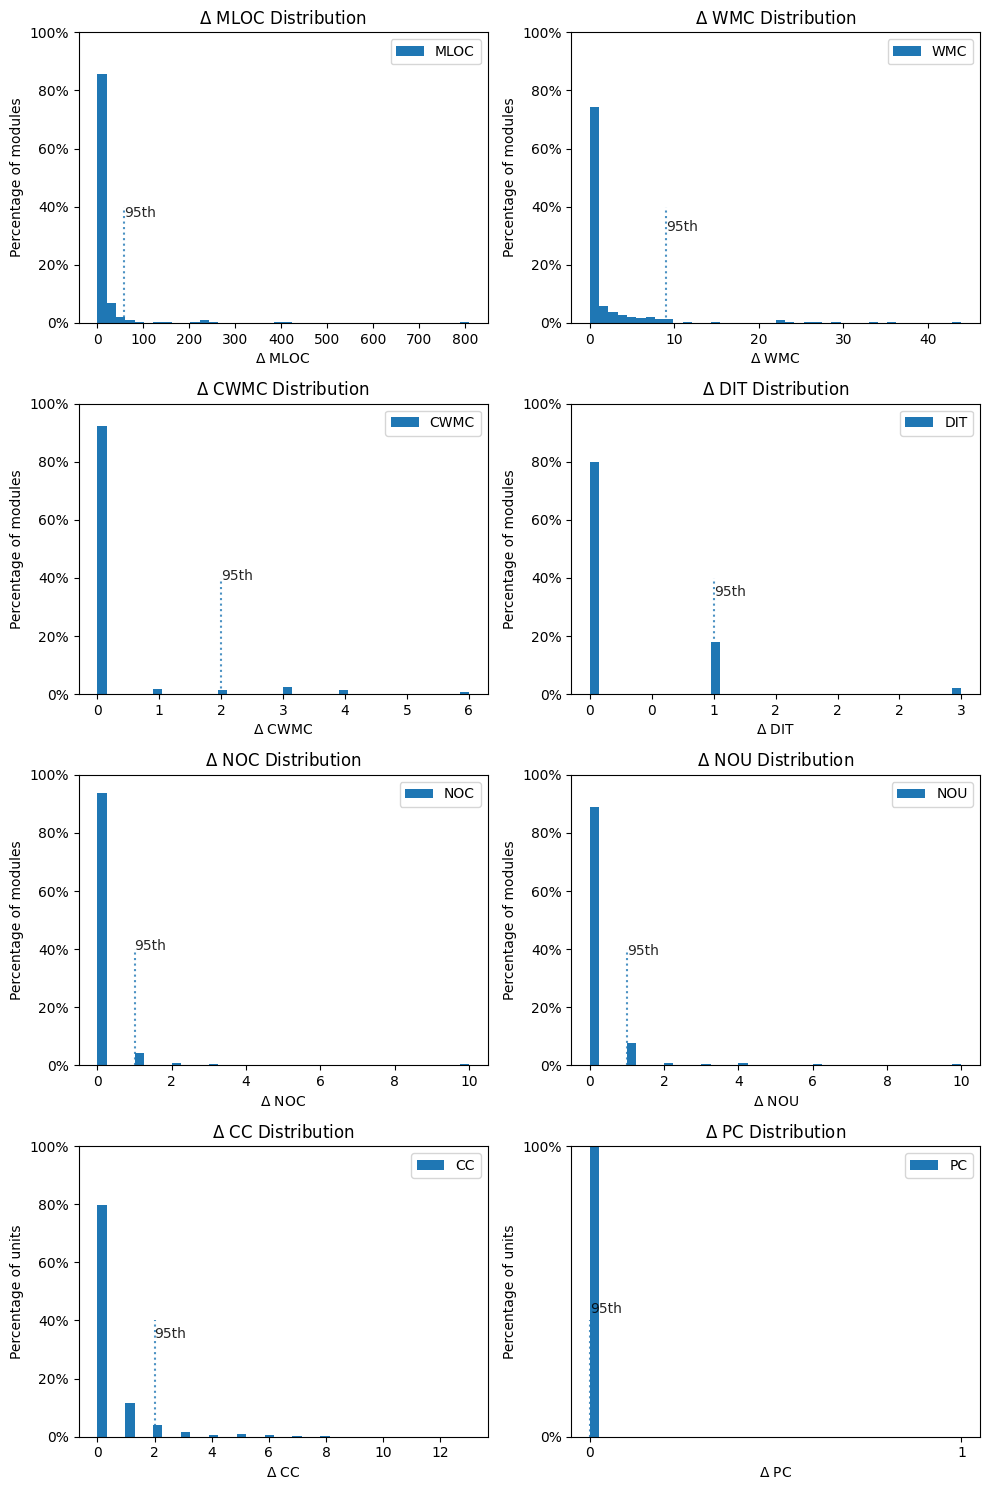

In [3843]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FormatStrFormatter

figure, axis = plt.subplots(4, 2, figsize=(10, 15))
plt.locator_params(axis="both", integer=True, tight=True)

def plot(subplot, df, metric: str, xlim = None, type = "modules"):
    y, x, _ = subplot.hist(df[f"DELTA_{metric}"], weights=np.ones(len(df[f"DELTA_{metric}"])) / len(df[f"DELTA_{metric}"]), bins=40, label=[metric])
    subplot.set(title= fr"$\Delta$ {metric} Distribution", xlabel= fr"$\Delta$ {metric}", ylabel=f'Percentage of {type}')
    subplot.yaxis.set_major_formatter(PercentFormatter(1))
    subplot.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    subplot.set_ylim([0, 1])
    subplot.legend()

    if xlim is not None:
        subplot.set_xlim(xlim)

    quant_95 = df[f"DELTA_{metric}"].quantile(0.95)
    subplot.axvline(quant_95, alpha=0.8, ymax = 0.4, linestyle = ":")
    subplot.text(quant_95, y.max() * 0.425, "95th", size = 10, alpha = 0.85)

plot(axis[0, 0], m, "MLOC")
plot(axis[0, 1], m, "WMC")
plot(axis[1, 0], m, "CWMC")
plot(axis[1, 1], m, "DIT")
plot(axis[2, 0], m, "NOC")
plot(axis[2, 1], m, "NOU")
plot(axis[3, 0], u, "CC", type="units")
plot(axis[3, 1], u, "PC", [-.05,1.05], type="units")

figure.tight_layout()
figure.savefig(f'images/{project}-distributions-percentage.png')

In [3823]:
def get_outliers(df, metric: str):
    outliers = df[df[f"DELTA_{metric}"] >= df[f"DELTA_{metric}"].quantile(0.95)]
    return outliers

In [3824]:
get_outliers(m, "MLOC").loc[:, ["DeclarableId", "D_LOC", "L_MLOC", "DELTA_MLOC"]].sort_values(by="DELTA_MLOC", ascending=False)

,DeclarableId,D_LOC,L_MLOC,DELTA_MLOC
188,org.antlr.v4.tool.Grammar,0,808,808
33,org.antlr.v4.semantics.BasicSemanticChecks,0,408,408
49,org.antlr.v4.codegen.Target,0,392,392
204,org.antlr.v4.tool.ErrorType,407,150,257
25,org.antlr.v4.parse.ScopeParser,0,239,239
198,org.antlr.v4.tool.ErrorManager,0,224,224
51,org.antlr.v4.codegen.ActionTranslator,0,212,212
6,org.antlr.v4.misc.CharSupport,0,154,154
177,org.antlr.v4.gui.PostScriptDocument,0,137,137
54,org.antlr.v4.codegen.target.GoTarget,0,92,92


In [3825]:
get_outliers(m, "WMC").loc[:, ["DeclarableId", "D_WMC", "L_WMC", "DELTA_WMC"]].sort_values(by="DELTA_WMC", ascending=False)

,DeclarableId,D_WMC,L_WMC,DELTA_WMC
171,org.antlr.v4.Tool,140,184,44
10,org.antlr.v4.automata.LexerATNFactory,126,162,36
38,org.antlr.v4.semantics.SymbolChecks,83,116,33
9,org.antlr.v4.automata.ParserATNFactory,92,121,29
188,org.antlr.v4.tool.Grammar,207,234,27
25,org.antlr.v4.parse.ScopeParser,56,82,26
6,org.antlr.v4.misc.CharSupport,40,64,24
18,org.antlr.v4.analysis.LeftRecursiveRuleAnalyzer,54,77,23
33,org.antlr.v4.semantics.BasicSemanticChecks,102,125,23
42,org.antlr.v4.codegen.ParserFactory,59,74,15


In [3826]:
get_outliers(u, "CC").loc[:, ["DeclarableId", "D_CC", "L_CC", "DELTA_CC"]].sort_values(by="DELTA_CC", ascending=False)

,DeclarableId,D_CC,L_CC,DELTA_CC
861,org.antlr.v4.parse.ScopeParser://_splitArgumentList,19,32,13
805,org.antlr.v4.misc.CharSupport://getStringFromGrammarStringLiteral,14,26,12
14,org.antlr.v4.Tool://handleArgs,18,27,9
696,org.antlr.v4.gui.Interpreter://interp,12,20,8
113,org.antlr.v4.automata.LexerATNFactory://createLexerAction,12,20,8
...,...,...,...,...
801,org.antlr.v4.misc.CharSupport://getCharValueFromCharInGrammarLiteral,10,12,2
806,org.antlr.v4.misc.CharSupport://parseHexValue,2,4,2
841,org.antlr.v4.misc.Utils://writeSerializedATNIntegerHistogram,4,6,2
903,org.antlr.v4.semantics.BasicSemanticChecks://checkCaseInsensitiveOption,5,7,2


In [3827]:
u[u["DELTA_CC"] > 1].loc[:, ["DeclarableId", "D_CC", "L_CC", "DELTA_CC"]].sort_values(by="DELTA_CC", ascending=False)

,DeclarableId,D_CC,L_CC,DELTA_CC
861,org.antlr.v4.parse.ScopeParser://_splitArgumentList,19,32,13
805,org.antlr.v4.misc.CharSupport://getStringFromGrammarStringLiteral,14,26,12
14,org.antlr.v4.Tool://handleArgs,18,27,9
696,org.antlr.v4.gui.Interpreter://interp,12,20,8
113,org.antlr.v4.automata.LexerATNFactory://createLexerAction,12,20,8
...,...,...,...,...
801,org.antlr.v4.misc.CharSupport://getCharValueFromCharInGrammarLiteral,10,12,2
806,org.antlr.v4.misc.CharSupport://parseHexValue,2,4,2
841,org.antlr.v4.misc.Utils://writeSerializedATNIntegerHistogram,4,6,2
903,org.antlr.v4.semantics.BasicSemanticChecks://checkCaseInsensitiveOption,5,7,2


In [3828]:
dcwmc = get_outliers(m, "CWMC").loc[:, ["DeclarableId", "S_COCO", "L_CWMC", "DELTA_CWMC"]].sort_values(by="DELTA_CWMC", ascending=False)
dcwmc

,DeclarableId,S_COCO,L_CWMC,DELTA_CWMC
171,org.antlr.v4.Tool,216,210,6
195,org.antlr.v4.tool.GrammarTransformPipeline,180,174,6
33,org.antlr.v4.semantics.BasicSemanticChecks,104,100,4
38,org.antlr.v4.semantics.SymbolChecks,184,180,4
179,org.antlr.v4.gui.TreeLayoutAdaptor,4,0,4
3,org.antlr.v4.misc.EscapeSequenceParsing,42,39,3
10,org.antlr.v4.automata.LexerATNFactory,182,179,3
26,org.antlr.v4.parse.TokenVocabParser,23,20,3
49,org.antlr.v4.codegen.Target,81,78,3
72,org.antlr.v4.codegen.model.RuleFunction,88,85,3


In [3829]:
print(f"CWMC Percentage diff: {(len(dcwmc) / len(m)) * 100}%")

CWMC Percentage diff: 6.11353711790393%


In [3830]:
get_outliers(m, "DIT").loc[:, ["DeclarableId", "D_DIT", "L_DIT", "DELTA_DIT"]].sort_values(by="DELTA_DIT", ascending=False)

,DeclarableId,D_DIT,L_DIT,DELTA_DIT
117,org.antlr.v4.codegen.model.InvokeRule,0,3,3
113,org.antlr.v4.codegen.model.ArgAction,1,4,3
105,org.antlr.v4.codegen.model.Action,0,3,3
211,org.antlr.v4.tool.ast.RuleAST,0,3,3
87,org.antlr.v4.codegen.model.SemPred,1,4,3
0,org.antlr.v4.misc.OrderedHashMap,0,1,1
216,org.antlr.v4.tool.ast.TerminalAST,2,3,1
205,org.antlr.v4.tool.Alternative,1,0,1
207,org.antlr.v4.tool.Rule,1,0,1
212,org.antlr.v4.tool.ast.SetAST,1,2,1


In [3831]:
m[m["DELTA_DIT"] == 1].loc[:, ["DeclarableId", "D_DIT", "L_DIT", "DELTA_DIT"]].sort_values(by="DELTA_DIT", ascending=False)

,DeclarableId,D_DIT,L_DIT,DELTA_DIT
0,org.antlr.v4.misc.OrderedHashMap,0,1,1
191,org.antlr.v4.tool.LeftRecursiveRule,2,1,1
205,org.antlr.v4.tool.Alternative,1,0,1
207,org.antlr.v4.tool.Rule,1,0,1
212,org.antlr.v4.tool.ast.SetAST,1,2,1
213,org.antlr.v4.tool.ast.GrammarRootAST,2,3,1
214,org.antlr.v4.tool.ast.PlusBlockAST,1,2,1
216,org.antlr.v4.tool.ast.TerminalAST,2,3,1
217,org.antlr.v4.tool.ast.StarBlockAST,1,2,1
218,org.antlr.v4.tool.ast.GrammarASTWithOptions,1,2,1


In [3832]:
get_outliers(m, "NOC").loc[:, ["DeclarableId", "D_NC", "L_NOC", "DELTA_NOC"]].sort_values(by="DELTA_NOC", ascending=False)
m[m["DELTA_NOC"] > 0].loc[:, ["DeclarableId", "D_NC", "L_NOC", "DELTA_NOC"]].sort_values(by="DELTA_NOC", ascending=False)

,DeclarableId,D_NC,L_NOC,DELTA_NOC
215,org.antlr.v4.tool.ast.RuleElementAST,10,0,10
210,org.antlr.v4.tool.ast.QuantifierAST,3,0,3
75,org.antlr.v4.codegen.model.RuleElement,2,4,2
192,org.antlr.v4.tool.AttributeResolver,2,0,2
9,org.antlr.v4.automata.ParserATNFactory,0,1,1
22,org.antlr.v4.parse.ActionSplitterListener,1,0,1
32,org.antlr.v4.semantics.BlankActionSplitterListener,0,1,1
41,org.antlr.v4.codegen.OutputModelFactory,1,0,1
69,org.antlr.v4.codegen.model.OutputModelObject,8,9,1
106,org.antlr.v4.codegen.model.LabeledOp,1,0,1


In [3833]:
dnoc = m[m["DELTA_NOC"] > 0].loc[:, ["DeclarableId", "D_NC", "L_NOC", "DELTA_NOC"]].sort_values(by="DELTA_NOC", ascending=False)
print(f"NOC Percentage diff: {(len(dnoc) / len(m)) * 100}%")

NOC Percentage diff: 6.11353711790393%


In [3834]:
dnou = m[m["DELTA_NOU"] > 0].loc[:, ["DeclarableId", "D_NOM", "L_NOU", "DELTA_NOU"]].sort_values(by="DELTA_NOU", ascending=False)
dnou

,DeclarableId,D_NOM,L_NOU,DELTA_NOU
175,org.antlr.v4.gui.TreeViewer,62,52,10
35,org.antlr.v4.semantics.UseDefAnalyzer,11,5,6
49,org.antlr.v4.codegen.Target,56,52,4
195,org.antlr.v4.tool.GrammarTransformPipeline,13,9,4
51,org.antlr.v4.codegen.ActionTranslator,14,17,3
207,org.antlr.v4.tool.Rule,26,28,2
196,org.antlr.v4.tool.ErrorSeverity,0,2,2
6,org.antlr.v4.misc.CharSupport,8,9,1
171,org.antlr.v4.Tool,39,40,1
204,org.antlr.v4.tool.ErrorType,0,1,1


In [3835]:
print(f"NOU Percentage diff: {(len(dnou) / len(m)) * 100}%")

NOU Percentage diff: 10.91703056768559%


In [3836]:
dpc = u.loc[:, ["DeclarableId", "D_PC", "L_PC", "DELTA_PC"]].sort_values(by=["DELTA_PC"], ascending=False).replace(to_replace=0, value=np.nan).dropna().drop_duplicates(subset="DeclarableId", keep=False)
dpc

,DeclarableId,D_PC,L_PC,DELTA_PC


In [3837]:
print(f"PC Percentage diff: {(len(dpc) / len(u)) * 100}%")


PC Percentage diff: 0.0%


In [3838]:
print(f"{project}\n\n#M:{len(m)}\n#U:{len(u)}\n")

antlr

#M:229
#U:1316



In [3839]:
table = """
\\begin{table}[H]
\centering
\\begin{tabular}{|l|r|}
\hline
\\textbf{Metric} & \\textbf{Exact Matches (\%)} \\\\ \hline
"""

table += """
MLOC            & {:.2%}                 \\\\ \hline
WMC             & {:.2%}                \\\\ \hline
CWMC            & {:.2%}                \\\\ \hline
DIT             & {:.2%}                \\\\ \hline
NOC             & {:.2%}                \\\\ \hline
NOU             & {:.2%}                \\\\ \hline
CC              & {:.2%}                \\\\ \hline
PC              & {:.2%}                \\\\ \hline
""".format(
    (len(m[m['DELTA_MLOC'] == 0]) / len(m)),
    (len(m[m['DELTA_WMC'] == 0]) / len(m)),
    (len(m[m['DELTA_CWMC'] == 0]) / len(m)),
    (len(m[m['DELTA_DIT'] == 0]) / len(m)),
    (len(m[m['DELTA_NOC'] == 0]) / len(m)),
    (len(m[m['DELTA_NOU'] == 0]) / len(m)),
    (len(u[u['DELTA_CC'] == 0]) / len(u)),
    (len(u[u['DELTA_PC'] == 0]) / len(u))
).replace("%", "\%")

table += """
\end{tabular}
\caption{\\textit{XXX} Metric Result Matches}
\label{table:XXX-metric-matches}
\end{table}
"""

print(table)


\begin{table}[H]
\centering
\begin{tabular}{|l|r|}
\hline
\textbf{Metric} & \textbf{Exact Matches (\%)} \\ \hline

MLOC            & 15.72\%                 \\ \hline
WMC             & 63.32\%                \\ \hline
CWMC            & 92.14\%                \\ \hline
DIT             & 79.91\%                \\ \hline
NOC             & 93.89\%                \\ \hline
NOU             & 89.08\%                \\ \hline
CC              & 79.71\%                \\ \hline
PC              & 100.00\%                \\ \hline

\end{tabular}
\caption{\textit{XXX} Metric Result Matches}
\label{table:XXX-metric-matches}
\end{table}

